In [40]:
# CLUSTER THE DATA

In [329]:
# import stuff
import scipy.io as sio
import scipy.signal as signal
import scipy.stats as stats
import pandas as pd 
import numpy as np
from array import *
import matplotlib.pyplot as plt
from array import *
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from astropy.convolution import convolve, Gaussian2DKernel, Gaussian1DKernel
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [75]:
def smooth(data, sigma, **kwargs):    
    d = data.ndim
    
    if  d == 2:
        kernel = Gaussian2DKernel(x_stddev = sigma)
    elif d == 1:
        kernel = Gaussian1DKernel(stddev = sigma)
    else:
        raise NotImplementedError("This function currently supports smoothing"\
                f" 1D, 2D data. You have provided {d} dimensional data")

    mask_fill = 0 

    mask_fill = kwargs.get('mask_fill', mask_fill)
    circular = kwargs.get("circular", False)
    if not isinstance(circular, bool):
        raise ValueError("You must provide a boolean (True/False) value for"\
                         f" keyword 'circular'. You provided {circular}, which"\
                         f" is type {type(circular)}")

    working_data = data.copy()
    if type(data) == np.ma.MaskedArray:
        working_data[data.mask] = mask_fill

    width = int(4*sigma)

    if circular:
        smoothed_data = convolve(working_data, kernel, boundary = "wrap")

    elif not circular:
        working_data = np.pad(working_data, pad_width = width, mode = 'symmetric')
        smoothed_data = convolve(working_data, kernel, boundary = 'extend')

    
        if d == 2:
            smoothed_data = smoothed_data[width:-width, width:-width]
        elif d == 1:
            smoothed_data = smoothed_data[width:-width]
        else: # This condition should never happen, due to checking above
            raise NotImplementedError("This function currently supports smoothing"\
                    f" 1D, 2D data. You have provided {d} dimensional data")

    if type(data) == np.ma.MaskedArray:
        smoothed_data = np.ma.masked_where(data.mask, smoothed_data)
        smoothed_data.data[data.mask] = data.data[data.mask]

    return smoothed_data

In [1]:
# load dataset
fileLoc = "D:\\Data\\Dataset\\25398\\25398_v2.mat"
matfile = sio.loadmat(fileLoc) # load .mat file

In [280]:
# pull out relevant information
cell_spikes = matfile["SpikeTimes"]
position = matfile["pos_cm"]
head_direction = matfile["hd"]
spiketrain = matfile["SpikeTrain"]
stype = matfile["sessType"]

In [330]:
class J:
    def __init__(self,  position, cell_spikes, spiketrain, head_direction, stype):
        self.position = position;
        self.cell_spikes = cell_spikes;
        self.spiketrain = spiketrain;
        self.head_direction = head_direction;
        self.stype = stype;
        
    def spikesNow(self, sessNum=0, unitNum=0):
        ST = self.cell_spikes[0][sessNum][0][unitNum][:,0]
        return ST
    
    def trainNow(self, sessNum=0, unitNum=0):
        strain = self.spiketrain[0][sessNum][0][unitNum][0]
        return strain
    
    def posNow(self, sessNum=0):
        P = self.position[0][sessNum];
        return P
    
    def trackingTimesNow(self, sessNum=0):
        t = self.position[0][sessNum][:,0];
        return t        
    
    def cellsInSession(self, sessNum =0):
        number_cells = np.size(spiketrain[0][sessNum][0]);
        return number_cells
    
    def getsesstype(self, sessNum=0):
        type_now = stype[0][sessNum][0]
        return type_now
        
    
    def clusterMe(self, sessNum=0):
        numNeurons = self.cellsInSession(sessNum)
        xPos = self.posNow(sessNum)[:,2]; 
        minX = np.min(np.ma.masked_array(xPos, np.isnan(xPos)))
        maxX = np.max(np.ma.masked_array(xPos, np.isnan(xPos)))
        tracking_times = self.trackingTimesNow(sessNum)
        head_angle = self.head_direction[0][sessNum];
        start_time = tracking_times[1]
        stop_time = tracking_times[-1]
        spikesDict = {}

        count = 1;
        for unitNum in range(0, numNeurons):
            spikes = self.spikesNow(sessNum, unitNum)

            if len(spikes) > 200:
                boolean_spk = np.logical_and(start_time <= spikes, spikes <= stop_time)
                spikes = spikes[boolean_spk == True]

                timeEdges = np.linspace(start_time, stop_time, np.size(tracking_times)+1) 
                binnedSpikes, timeEdges = np.histogram(spikes, timeEdges)
                time_ind = np.digitize(tracking_times, timeEdges);

                binnedSpikes_smooth = smooth(binnedSpikes, 10)
                binnedSpikes_smoothNorm = stats.zscore(binnedSpikes_smooth) 
                spikesDict['N{}'.format(count)] = binnedSpikes_smoothNorm;
                count = count + 1

        HDnum_bins = 60 # 6 degree bins
        hdEdges = np.linspace(0, 360, HDnum_bins)
        hdOccupancy, hdEdges_hist = np.histogram(head_angle, bins = HDnum_bins, range = (0, 360)); 
        angle_ind = np.digitize(head_angle, hdEdges_hist);

        x_bins = 100;
        xEdges = np.linspace(minX, maxX, x_bins+1);
        binnedSpikes, xEdgesHist = np.histogram(xPos, xEdges)
        x_ind = np.digitize(xPos, xEdgesHist);
        
        X = pd.DataFrame.from_dict(spikesDict)
        pca = PCA(n_components = 3, whiten = True)
        out = pca.fit_transform(X)
        principalDf = pd.DataFrame(data = out, columns = ['PC1', 'PC2', 'PC3'])
        principalDf['HA'] = angle_ind
        principalDf['X'] = x_ind
        
        fig = plt.figure(figsize=(8,6))
        sns.set(style = "whitegrid")
        ax = fig.add_subplot(111, projection = '3d')
        PC1 = principalDf['PC1']
        PC2 = principalDf['PC2']
        PC3 = principalDf['PC3']
        HA = principalDf['HA']
        X = principalDf['X']
        ax.scatter(PC1, PC2, PC3, s = 2, alpha = .2, c=X, cmap='rainbow');
        plt.title(self.getsesstype(sessNum), fontsize=20);

In [331]:
# initiate instances of class bebhaVid
J1 = J(position, cell_spikes, spiketrain, head_direction, stype)

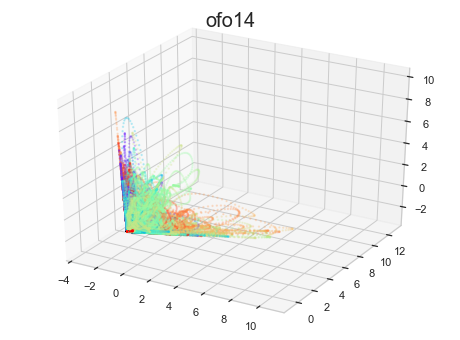

In [337]:
J1.clusterMe(86)

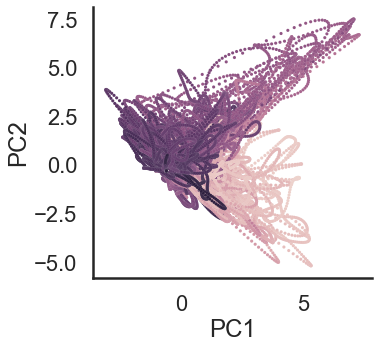

In [327]:
X = pd.DataFrame.from_dict(spikesDict)
pca = PCA(n_components = 3, whiten = True)
out = pca.fit_transform(X)
principalDf = pd.DataFrame(data = out, columns = ['PC1', 'PC2', 'PC3'])
principalDf['HA'] = angle_ind
principalDf['X'] = x_ind
principalDf.head()

plt.ion
import seaborn as sns
sns.set(context = 'poster', style = 'white', font_scale = 1)
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x="PC1", y="PC2", hue='X', linewidth = .05, s=10, data=principalDf, cmap='rainbow')
ax.legend_.remove()
sns.despine()